<a href="https://colab.research.google.com/github/alvinrach/Multilabel-IMDB-Poster-Genre/blob/main/IMDB_Poster_13_Genre_Detection_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we'll create mulitlabel prediction on the IMDB poster-genre dataset. Since it's multilabel, one poster may have more than one label.

In [1]:
!mkdir -p ~/.kaggle
!echo '{"username":"alvinrach","key":"01d0bc7e09928966a5b93eabab748737"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dadajonjurakuziev/movieposter

 99% 826M/838M [00:03<00:00, 222MB/s]
100% 838M/838M [00:03<00:00, 223MB/s]


In [2]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_41K/img_41K/5496.jpg  
  inflating: img_41K/img_41K/5497.jpg  
  inflating: img_41K/img_41K/5498.jpg  
  inflating: img_41K/img_41K/5499.jpg  
  inflating: img_41K/img_41K/55.jpg  
  inflating: img_41K/img_41K/550.jpg  
  inflating: img_41K/img_41K/5500.jpg  
  inflating: img_41K/img_41K/5501.jpg  
  inflating: img_41K/img_41K/5502.jpg  
  inflating: img_41K/img_41K/5503.jpg  
  inflating: img_41K/img_41K/5504.jpg  
  inflating: img_41K/img_41K/5505.jpg  
  inflating: img_41K/img_41K/5506.jpg  
  inflating: img_41K/img_41K/5507.jpg  
  inflating: img_41K/img_41K/5508.jpg  
  inflating: img_41K/img_41K/5509.jpg  
  inflating: img_41K/img_41K/551.jpg  
  inflating: img_41K/img_41K/5510.jpg  
  inflating: img_41K/img_41K/5511.jpg  
  inflating: img_41K/img_41K/5512.jpg  
  inflating: img_41K/img_41K/5513.jpg  
  inflating: img_41K/img_41K/5514.jpg  
  inflating: img_41K/img_41K/5515.jpg  
  inflating: img_41K/img_41K/5516

In [3]:
import os
img_path = '/content/img_41K/img_41K/'
len(os.listdir(img_path))

83958

In [4]:
import pandas as pd
import numpy as np
d = pd.read_csv('/content/duplicate_free_41K.csv')
d

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41974,42016,https://m.media-amazon.com/images/M/MV5BMTgxNz...,Demon Empire,2006,6.2,"action, adventure, drama",1,1,0,0,0,1,0,0,0,0,0,0,0
41975,42017,https://m.media-amazon.com/images/M/MV5BNGZiNz...,ZsaZsa Zaturnnah Ze Moveeh,2006,6.2,"action, adventure, comedy",1,1,0,1,0,0,0,0,0,0,0,0,0
41976,42018,https://m.media-amazon.com/images/M/MV5BMTIwOT...,Running with Scissors,2006,6.2,"comedy, drama",0,0,0,1,0,1,0,0,0,0,0,0,0
41977,42019,https://m.media-amazon.com/images/M/MV5BMzJiM2...,To Let,2006,6.2,"horror, thriller",0,0,0,0,0,0,0,1,0,0,0,0,1


In [5]:
# We will just use a quarter of the data since the Colab RAM isn't enough if we use all of the data
d = d.loc[np.random.choice(d.index, 10000, replace=False)].reset_index(drop=True)
d

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,14452,https://m.media-amazon.com/images/M/MV5BZWM5N2...,A Few Less Men,2017,4.8,"adventure, comedy",0,1,0,1,0,0,0,0,0,0,0,0,0
1,32606,https://m.media-amazon.com/images/M/MV5BMTAzNz...,Hollow,2011,5.6,"horror, mystery, thriller",0,0,0,0,0,0,0,1,1,0,0,0,1
2,5178,https://m.media-amazon.com/images/M/MV5BZTBhZm...,Pezzi Unici,2019,5.6,"drama, mystery",0,0,0,0,0,1,0,0,1,0,0,0,0
3,13554,https://m.media-amazon.com/images/M/MV5BNmRiZD...,Jigsaw,2017,5.8,"crime, horror, mystery",0,0,0,0,1,0,0,1,1,0,0,0,0
4,35354,https://m.media-amazon.com/images/M/MV5BMjI0Mz...,Super Hybrid,2010,3.9,"horror, sci-fi, thriller",0,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,35654,https://m.media-amazon.com/images/M/MV5BZWRiNz...,inFamous,2009,8.1,"action, adventure, sci-fi",1,1,0,0,0,0,0,0,0,0,1,0,0
9996,12278,https://m.media-amazon.com/images/M/MV5BYWExZW...,Empire of the Heart,2017,7.0,"crime, drama",0,0,0,0,1,1,0,0,0,0,0,0,0
9997,16502,https://m.media-amazon.com/images/M/MV5BYzkyYT...,The Stylist,2016,6.9,"short, drama, horror",0,0,0,0,0,1,0,1,0,0,0,1,0
9998,8785,https://m.media-amazon.com/images/M/MV5BOTYwOD...,A Dark Place,2018,6.2,"mystery, thriller",0,0,0,0,0,0,0,0,1,0,0,0,1


In [6]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

x_size = 210
y_size = 210
X = []
for i in tqdm(range(d.shape[0])):
  path = img_path+str(d['id'][i])+'.jpg'
  img = image.load_img(path,target_size=(x_size,y_size,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

100%|██████████| 10000/10000 [00:27<00:00, 359.29it/s]


In [7]:
X.shape

(10000, 210, 210, 3)

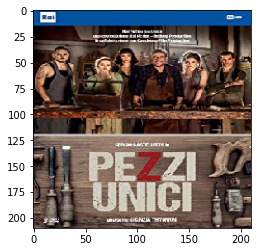

In [8]:
import matplotlib.pyplot as plt
plt.imshow(X[2])

In [9]:
d['genre'][2]

'drama, mystery'

In [10]:
y = d.drop(['id','poster','title','year','rating','genre'], 1).values
del d
y.shape

(10000, 13)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
del X
del y

In [20]:
import tensorflow as tf

# Sigmoid activation is used in the output layer since it's a multilabel prediction

model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(x_size, y_size,3)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
    ]
)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 210, 210, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 105, 105, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 105, 105, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 52, 52, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 128)      

In [22]:
# For tensorflow >= 2.2.0, don't forget to set to the binary_accuracy instead just accuracy in metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor = 'val_binary_accuracy',
    save_best_only = True,
    verbose = 1
)

set_callback = [checkpoint]

history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test), callbacks=set_callback)

Epoch 1/20
250/250 [==============================] - 62s 43ms/step - loss: 0.4480 - binary_accuracy: 0.8190 - val_loss: 0.4307 - val_binary_accuracy: 0.8243

Epoch 00001: val_binary_accuracy improved from -inf to 0.82427, saving model to model.h5
Epoch 2/20
250/250 [==============================] - 11s 42ms/step - loss: 0.4287 - binary_accuracy: 0.8239 - val_loss: 0.4276 - val_binary_accuracy: 0.8247

Epoch 00002: val_binary_accuracy improved from 0.82427 to 0.82465, saving model to model.h5
Epoch 3/20
250/250 [==============================] - 11s 43ms/step - loss: 0.4240 - binary_accuracy: 0.8254 - val_loss: 0.4220 - val_binary_accuracy: 0.8260

Epoch 00003: val_binary_accuracy improved from 0.82465 to 0.82600, saving model to model.h5
Epoch 4/20
250/250 [==============================] - 11s 43ms/step - loss: 0.4211 - binary_accuracy: 0.8254 - val_loss: 0.4214 - val_binary_accuracy: 0.8265

Epoch 00004: val_binary_accuracy improved from 0.82600 to 0.82646, saving model to model.h5

In [24]:
model.load_weights("model.h5")
model.evaluate(X_test,y_test)

63/63 [==============================] - 1s 18ms/step - loss: 0.4004 - binary_accuracy: 0.8299


[0.4004443287849426, 0.8299230933189392]

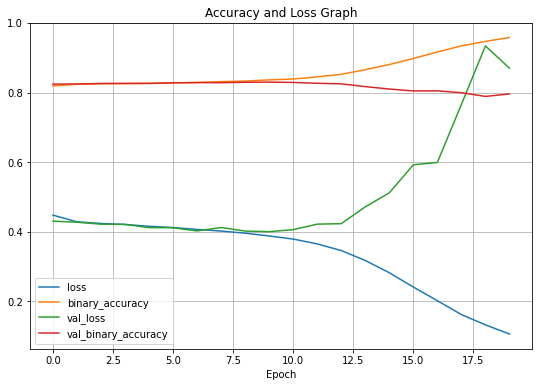

In [25]:
# Plotting loss and accuracy, train and validation, each epoch
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid()